#  Voter turnout analysis of Municipalities of Switzerland

## Install and import libraries

In [1]:
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install nbconvert[webpdf]
#!pip install colorcet
#!pip install selenium 
#!pip install geckodriver

# https://docs.bokeh.org/en/2.4.3/docs/user_guide/export.html
# conda install selenium geckodriver -c conda-forge
# conda install firefox -c conda-forge

In [70]:
import math
import copy
import json
import sys

from PIL import Image

import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt 
import statsmodels.api   as sm

from sklearn         import linear_model
from sklearn.metrics import r2_score

from scipy       import stats 
from scipy.stats import linregress, gaussian_kde, norm

import colorcet as cc

from bokeh.plotting import figure, show
from bokeh.palettes import Inferno11
from bokeh.layouts  import column, row
from bokeh.models   import ColumnDataSource, LabelSet, Slope, TextInput, FuncTickFormatter, CustomJSTickFormatter
from bokeh.models   import InlineStyleSheet, Button, RangeSlider, CustomJS, Title
from bokeh.models   import FixedTicker, PrintfTickFormatter
from bokeh          import events
from bokeh.io       import export_png 

## Read data

In [28]:
municipalities   = pd.read_csv("data/preprocessed/je-d-21.03.01-gemeindeportraits-preprocessed.csv",       sep=";")
commune_register = pd.read_csv("data/preprocessed/be-t-00.04-agv-01-amtliches-gemeindeverzeichnis.csv",    sep=";")
turnouts2023     = pd.read_csv("data/original/sd-t-17.02-NRW2023-wahlbeteiligung-appendix.csv",            sep=";")
turnouts2019     = pd.read_csv("data/original/sd-t-17.02-NRW2019-wahlbeteiligung-gemeinden-APPENDIX.csv",  sep=";")

# Élections cantonales neuchâteloises de 2021: Evolution du taux de participation
# https://www.ne.ch/autorites/CHAN/CHAN/elections-votations/stat/Pages/210418.aspx
turnoutsNE       = pd.read_csv("data/preprocessed/ne-2021-04-18-cantonal-elections.csv",                    sep=";")

## Select relevant columns and rows

In [29]:
turnouts2023 = turnouts2023.loc[turnouts2023["ebene_resultat"] != "Schweiz" ]
turnouts2023 = turnouts2023.loc[turnouts2023["ebene_resultat"] != "Kanton" ]

turnouts2019 = turnouts2019[ ["gemeinde_bezeichnung", "wahlbeteiligung"] ]
turnouts2023 = turnouts2023[ ["geoLevelName", "wahlbeteiligung"] ]

commune_register = commune_register[ ["Name of commune", "Canton"] ]

municipalities.drop(columns=["Number of commune"], inplace=True)

In [30]:
municipalities.head(10)

,Name of commune,Residents,Change in %,Population density per km²,Foreign nationals in %,0-19 years,20-64 years,65 years or over,Crude marriage rate,Crude divorce rate,...,Primary sector,Secondary sector,Tertiary sector,Business establishments total,Primary sector.1,Secondary sector.1,Tertiary sector.1,Dwelling vacancy rate,New housing units per 1000 residents,Social assistance rate
0,Aeugst am Albis,1981,8.607456,250.442478,14.184755,19.787986,62.190813,18.021201,7.065355,2.018673,...,39.0,25.0,378.0,141.0,15.0,16.0,110.0,5.291577,13.910355,1.01
1,Affoltern am Albis,12303,10.927779,1161.756374,28.700317,20.165813,61.667886,18.166301,5.543780,1.793576,...,47.0,1307.0,5566.0,995.0,23.0,134.0,838.0,1.005548,3.787255,3.02
2,Bonstetten,5572,8.005427,749.932705,16.564968,23.636037,59.834889,16.529074,4.316547,1.798561,...,34.0,111.0,869.0,281.0,14.0,26.0,241.0,1.171717,0.181422,1.51
3,Hausen am Albis,3751,11.636905,275.808824,16.022394,22.180752,59.824047,17.995201,3.220612,1.610306,...,93.0,136.0,792.0,271.0,36.0,38.0,197.0,0.630011,3.002183,1.19
4,Hedingen,3778,10.791789,578.560490,16.410799,21.625199,61.646374,16.728428,3.727370,2.129925,...,29.0,679.0,770.0,201.0,11.0,26.0,164.0,0.962696,3.248511,1.47
5,Kappel am Albis,1221,33.006536,154.166667,17.526618,24.979525,61.179361,13.841114,3.364172,0.000000,...,56.0,81.0,182.0,101.0,21.0,24.0,56.0,2.177858,37.333333,0.69
6,Knonau,2378,32.111111,367.542504,18.292683,24.348192,60.975610,14.676198,3.367712,0.841928,...,55.0,108.0,403.0,133.0,24.0,15.0,94.0,0.588235,5.639913,0.84
7,Maschwanden,645,4.707792,137.526652,12.868217,22.015504,59.534884,18.449612,3.074558,0.000000,...,49.0,49.0,77.0,67.0,18.0,7.0,42.0,2.990033,0.000000,NaN
8,Mettmenstetten,5200,22.554796,399.079048,14.769231,23.096154,59.211538,17.692308,5.051486,2.331455,...,148.0,545.0,987.0,319.0,51.0,58.0,210.0,1.325088,18.215309,1.61
9,Obfelden,5721,22.087068,758.753316,21.464779,23.579794,59.639923,16.780283,4.946996,1.943463,...,51.0,310.0,891.0,307.0,17.0,60.0,230.0,2.145411,7.281553,2.57


## Rename some column names

In [31]:
turnouts2023.rename(columns = {
    'wahlbeteiligung': 'turnout2023', 
    'geoLevelName':    'Municipality'
},  inplace = True)

In [32]:
turnouts2019.rename(columns = {
    'wahlbeteiligung':         'turnout2019', 
    'gemeinde_bezeichnung':    'Municipality'
},  inplace = True)

In [33]:
municipalities.rename(columns = {
  'Name of commune':          'Municipality',
  'Foreign nationals in %':   'Percentage of foreign nationals'
}, inplace = True)

In [34]:
commune_register.rename(columns = {
  'Name of commune': 'Municipality'
}, inplace = True)

## Merge data frames

In [35]:
data = pd.merge(municipalities, turnouts2023, on='Municipality', how='inner')
data = pd.merge(data, turnouts2019,           on='Municipality', how='left')
data = pd.merge(data, turnoutsNE,             on='Municipality', how='left')
data = pd.merge(data, commune_register,       on='Municipality', how='left')

In [39]:
# Check for missing values
data.describe(include='all') 
#data[["Total surface area in km2"]].describe() 

,Municipality,Residents,Change in %,Population density per km²,Percentage of foreign nationals,0-19 years,20-64 years,65 years or over,Crude marriage rate,Crude divorce rate,...,Primary sector.1,Secondary sector.1,Tertiary sector.1,Dwelling vacancy rate,New housing units per 1000 residents,Social assistance rate,turnout2023,turnout2019,turnout_Neuchatel_2021,Canton
count,2128,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,...,1986.000000,1975.000000,2109.000000,2128.000000,2128.000000,1668.000000,2128.000000,2109.000000,27.000000,2128
unique,2128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26
top,Aeugst am Albis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bern
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,332
mean,NaN,4028.617951,9.250516,442.626451,16.976537,20.482493,60.128050,19.389457,4.160414,1.916991,...,26.453172,48.056203,254.248459,1.956082,6.198459,2.219430,48.969156,47.110005,36.842222,NaN
std,NaN,12998.766750,11.356776,799.421675,9.689512,3.360132,3.159266,4.417717,2.474005,1.750014,...,28.418553,103.023538,1239.686438,1.681838,8.478068,1.626157,7.979742,7.742767,7.483881,NaN
min,NaN,32.000000,-30.311778,0.860165,0.000000,2.127660,39.534884,6.461538,0.000000,0.000000,...,0.000000,0.000000,4.000000,0.000000,0.000000,0.220000,21.867322,23.160763,27.750000,NaN
25%,NaN,745.500000,2.510204,80.909278,9.600977,18.735814,58.285379,16.377225,2.874080,1.020148,...,9.000000,11.000000,34.000000,0.790358,0.758974,1.130000,43.861899,41.767442,30.270000,NaN
50%,NaN,1605.500000,7.977146,187.850086,15.182499,20.588235,60.242180,18.999233,4.039331,1.787470,...,17.000000,24.000000,76.000000,1.547626,3.385557,1.745000,48.758835,46.510873,36.210000,NaN
75%,NaN,3914.250000,14.398003,477.254590,23.179496,22.542042,62.136243,21.626464,5.202463,2.473717,...,33.000000,53.000000,189.000000,2.675573,8.251393,2.762500,53.588445,51.443375,40.440000,NaN


## Define voter turnout and municipality columns (name and canton)

In [12]:
voter_turnout_columns = ['turnout2019', 'turnout2023', 'turnout_Neuchatel_2021']
municipality_columns  = ["Municipality", "Canton"]

## Create copy with standardized values

In [13]:
data_std = copy.deepcopy(data)
for column in data_std.columns:
  if column not in municipality_columns:
    data_std[column] = stats.zscore(data_std[column], nan_policy="omit")

## Create plots

### Histogram for voter turnout 2023

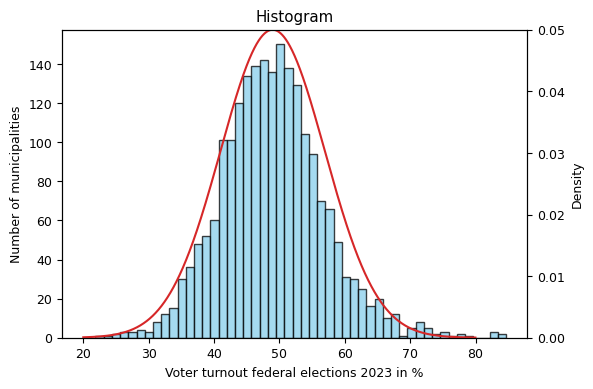

In [114]:
fig, ax1 = plt.subplots(1, 1,figsize=(6, 4))
plt.title("Histogram")
ax1.set_ylabel("Number of municipalities")
ax1.set_xlabel("Voter turnout federal elections 2023 in %")
ax1.hist(data['turnout2023'], bins=50, ec="black", color="skyblue", alpha=0.75)
ax2 = ax1.twinx()
ax2.set_ylim(bottom=0, top=0.05)
ax2.set_ylabel("Density")
ax2.plot(
    np.arange(20, 80, 0.01), 
    norm.pdf(np.arange(20, 80, 0.01), data['turnout2023'].mean(), data['turnout2023'].std()), 
    color='tab:red'
)

### Ridge plot per canton

In [44]:
# https://docs.bokeh.org/en/latest/docs/examples/topics/categorical/ridgeplot.html$

def ridge(canton, data, scale=15):
    return list(zip([canton]*len(data), scale*data))


def ridge_plot(cantons, number=1):
    
  # Define colors for the 26 Cantons
  ncolors = 20
  if len(cantons) > 13:
    ncolors = 10
    
  palette = [cc.rainbow[i*ncolors] for i in range(len(cantons))]


  # Define range for x-axis
  x_min = 10
  x_max = 80
  x = np.linspace(x_min, x_max, 500)

  source = ColumnDataSource(data=dict(x=x))

  p = figure(y_range=cantons, height=len(cantons)*40, width=400, x_range=(x_min, x_max), toolbar_location=None)

  # Create a ridge for each canton
  for i, canton in enumerate(cantons):
    probly = data[data['Canton'] == canton]
    residents = probly['Residents']
    probly = probly[["turnout2023"]].squeeze()        
    pdf = gaussian_kde(probly, weights=residents)
    y = ridge(canton, pdf(x))
    source.add(y, canton)
    p.patch('x', canton, color=palette[i], alpha=0.7, line_color="black", source=source)

  p.outline_line_color = None
  p.background_fill_color = "#efefef"

  p.xaxis.axis_label = "Voter turnout federal elections 2023"
  p.xaxis.ticker = FixedTicker(ticks=list(range(0, 101, 10)))
  p.xaxis.formatter = PrintfTickFormatter(format="%d%%")

  p.xgrid.grid_line_color = "#dddddd"
  p.ygrid.grid_line_color = None

  p.y_range.range_padding = 0.065

  export_png(p, filename="plots/voter-turnout-kde-per-canton-%d.png" % number)

In [45]:
cantons = list(data['Canton'].unique())

# Create two plots to make it more readable

# Cantons 1 to 13
cantons1 = cantons[0:13]
ridge_plot(cantons1, 2)

# Cantons 14 to 26
cantons2 = cantons[13:27]
ridge_plot(cantons2, 1)

### Histogram for each input variable

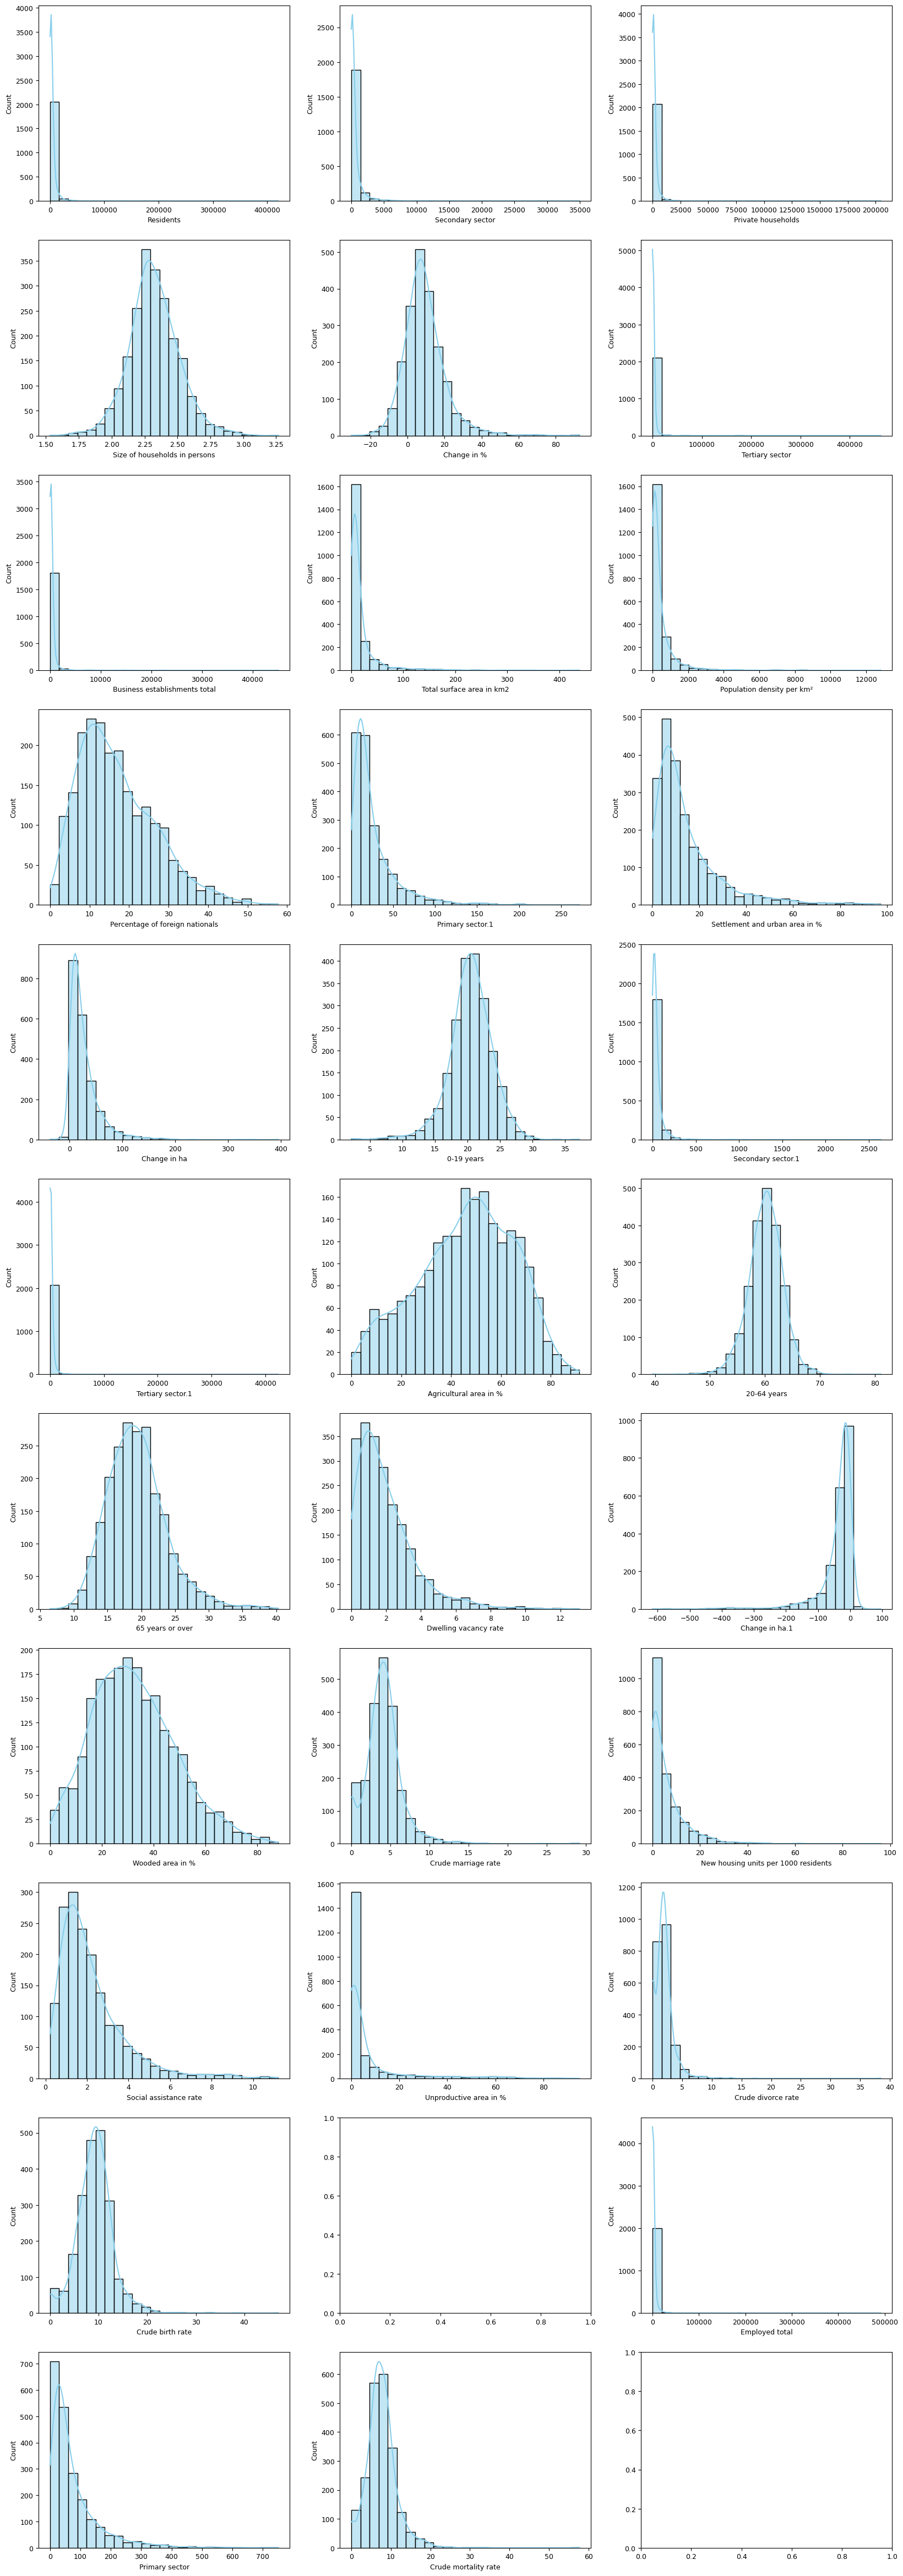

In [46]:
fig, axs = plt.subplots(11, 3, figsize=(20, 60))
i = 0
for column in data.columns:
  if column not in municipality_columns and column not in voter_turnout_columns:
    sns.histplot(data=data, bins=25, x=column, kde=True, color="skyblue", ax=axs[ i % 11, i % 3])
    i = i+1

### Bar chart with correlation coefficients
Calculate Pearsons correlation coeffiecient for each input variable and the voter turnout from 2023.
As a comparison value we use the the voter turnout from 2019.

In [47]:
correlations = pd.DataFrame()
m = 0
for column in data_std.columns:
  if column not in municipality_columns and column not in voter_turnout_columns:
    mask = data_std[column].isna()
    df = data_std[~mask]
    df = df[[column, "turnout2023", "turnout2019"]]
    if len(df.index) > 0:
      new_row = pd.DataFrame({ 
        'correlation 2023' : df['turnout2023'].corr(df[column]),
        'correlation 2019' : df['turnout2019'].corr(df[column])
    }, index=[column])
    correlations = pd.concat([new_row, correlations.loc[:]]) #.reset_index(drop=True)

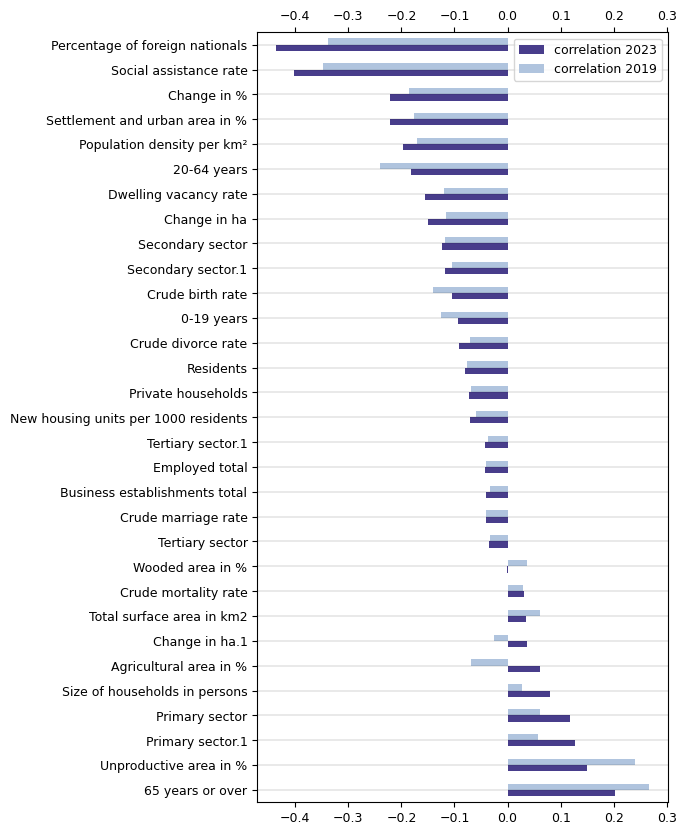

In [49]:
correlations = correlations.sort_values("correlation 2023", ascending=False)     
plt.rcParams.update({'font.size': 9 })
ax = correlations.plot.barh(figsize=(5.3,10), color=["#483D8B", "#B0C4DE"])
ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
ax.grid(color='black', linewidth=0.25, axis='y', alpha=0.5)
ax.legend(loc='upper right')

### Scatter plots with linear regression line

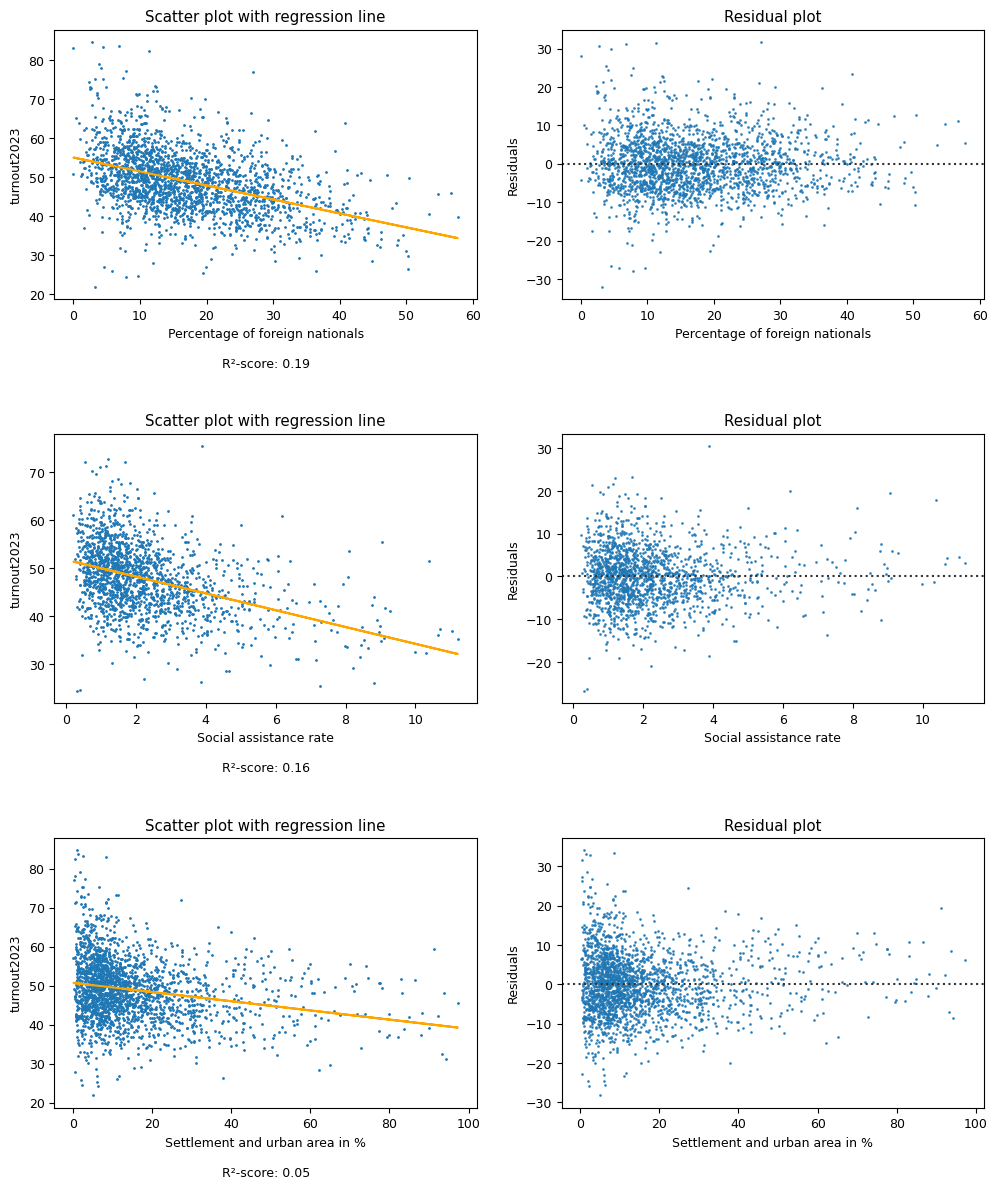

In [50]:
columnsX = ['Percentage of foreign nationals', 'Social assistance rate', 'Settlement and urban area in %'] # Residents 65+ years (%)
columnY = "turnout2023" #
fig, axs = plt.subplots(3, 2, figsize=(12, 14))

# Add more vertical space between the subplots
plt.subplots_adjust(hspace=0.5)

i = 0
for column in columnsX:

  # remove NaN values
  df = data[~data[column].isna()] 

  # linear regression with scipy
  x = df[column].astype(float)
  y = df[columnY].astype(float)
    
  slope, intercept, r, p, se = linregress(x=x, y=y)
    
  # Create the scatter plot with regression line on the ax in the first column
  axs[i, 0].set_title("Scatter plot with regression line")
  axs[i, 0].scatter(df[column], df[columnY], s = 1)
  axs[i, 0].plot(x, x*slope + intercept, color="orange")
  axs[i, 0].set_xlabel(column + '\n\nR²-score: ' + str(round(r2_score(y, x*slope + intercept), 2)))
  axs[i, 0].set_ylabel(columnY)

  # Create the residual plot (with seaborn) on the ax in the second column (see paramter ax in residplot)
  axs[i, 1].set_title("Residual plot")
  sns.residplot(x=column, y=columnY, data=df, scatter_kws=dict(s=1), ax=axs[i, 1])
  axs[i, 1].set_ylabel("Residuals")

  i = i + 1

Text(0, 0.5, 'turnout_Neuchatel_2021')

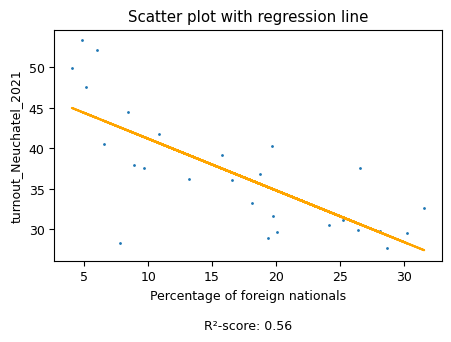

In [51]:
columnX = "Percentage of foreign nationals"
columnY = "turnout_Neuchatel_2021"
fig, axs = plt.subplots(1, 1, figsize=(5, 3))

# remove NaN values
df = data[~data[columnY].isna()] 

# linear regression with scipy
x = df[columnX].astype(float)
y = df[columnY].astype(float)
slope, intercept, r, p, se = linregress(x, y)
    
axs.set_title("Scatter plot with regression line")
axs.scatter(df[columnX], df[columnY], s = 1)
axs.plot(x, x*slope + intercept, color="orange")
axs.set_xlabel(columnX + '\n\nR²-score: ' + str(round(r2_score(y, x*slope + intercept), 2)))
axs.set_ylabel(columnY)

### Interactive scatter plot with bokeh

In [55]:
# https://docs.bokeh.org/en/latest/docs/examples/basic/scatters/elements.html
from bokeh.models import Title

## Define columns and remove NaN values
columnX = "Percentage of foreign nationals"
columnY = "turnout2023"
df = data[~data[columnX].isna()] 
    
# Set up the plot: title, tools, sizing mode, margins, colors, labels etc.
TITLE   = "Interactice scatter plot: Each point represents a Municipality (use MoseOver to see the name)"
TOOLS   = "hover,pan,wheel_zoom,reset,save"

p = figure(tools=TOOLS, toolbar_location="above", sizing_mode='stretch_both', title=TITLE, margin=(25,50,25,25))

p.toolbar.logo = "grey"
p.background_fill_color = "#efefef"
p.xaxis.axis_label = columnX
p.yaxis.axis_label = "Voter turnout federal elections 2023"
p.grid.grid_line_color = "white"
p.hover.tooltips = [
    ("Municipality name",   "@Municipality"),
    ("Number of residents", "@Residents"),
    ("Total area in km2", "@{Total surface area in km2}"),
    ("Voter turnout federal elections 2023", "@{turnout2023}%"),
    (columnX, "@{Percentage of foreign nationals}%")
]

x = df[columnX]
y = df[columnY]

# Create the ColumnDataSource and AFTER that add values for color and size of the plot points
# Otherwise the s.change.emit() in the callback function will have no effect
source = ColumnDataSource(df)

source.data["color"] = ["steelblue"] * len(x) # steelblue
source.data["size"] = [5] * len(x)

# Use one callback function for all iterative elements (text search, range slider and reset button)
callback = CustomJS(args=dict(s=source), code="""
      
    const d = s.data;
    const m = d['Municipality']
    const v = d['Residents']
    
    
    // Set all points to default value
    for (let i = 0; i < d['color'].length; i++) {
        d['color'][i] = "steelblue"
        d['size'][i]  = 5
    }

    // Text search: Highlight municipalities whose names match the search term
    if( typeof cb_obj.value == 'string' ) {
      const search = cb_obj.value.toLowerCase()
      if( search.length > 0 ) {
        for (let i = 0; i < m.length; i++) {
          if( m[i].toLowerCase().includes(search) == true ) {
            d['color'][i] = "firebrick"
            d['size'][i]  = 10
          }
        }
      }
    }
    
    // Range slider: Highlight municipalities whose number residents lies within the selected range
    
    if( typeof cb_obj.value == 'object' ) {
      
      const v_min = Math.exp(cb_obj.value[0]).toFixed(0)
      const v_max = Math.exp(cb_obj.value[1]).toFixed(0)
      
      // Only highlight if some range is selected
      if( v_min > 3 || v_max < 442413 ) {
        for (let i = 0; i < m.length; i++) {
          if( v[i] >= v_min && v[i] <= v_max ) {
            d['color'][i] = "firebrick"
            d['size'][i]  = 7
          }
        }
      }
    }

    s.change.emit();

""")

    
callbackAreaSlider = CustomJS(args=dict(s=source), code="""
      
    const d = s.data;
    const area = d['Total surface area in km2']
    
    
    // Set all points to default value
    for (let i = 0; i < d['color'].length; i++) {
        d['color'][i] = "steelblue"
        d['size'][i]  = 5
    }

    // Range slider: Highlight municipalities whose are lies within the selected rang
    const v_min = cb_obj.value[0]
    const v_max = cb_obj.value[1]
      
    // Only highlight if some range is selected
    if( v_min > 0 || v_max < 450 ) {
      for (let i = 0; i < area.length; i++) {
        if( area[i] >= v_min && area[i] <= v_max ) {
          d['color'][i] = "firebrick"
          d['size'][i]  = 7
        }
      }
    }

    s.change.emit();

""")


# Create scatter plot
p.scatter(columnX, columnY, size="size", source=source, color="color", line_width=0, line_color="black", alpha=1)

# Linear regression with scipy
slope, intercept, r2, p_1, se = linregress(x, y)
slope = Slope(gradient=slope, y_intercept=intercept, line_color=Inferno11[8], line_width=2)
p.add_layout(slope)

# Create search field
search_input_css = InlineStyleSheet(css=".bk-input-group { padding: 25px 0px 0px 60px }")
search_input = TextInput(value="", title="Search by Municipality name", stylesheets=[search_input_css])
search_input.js_on_change("value", callback)

# Create range slider for number of residents
#s = Slider(start=0, end=1, value=0.5, step=0.1, format=FuncTickFormatter(code="return Math.exp(tick).toFixed(2)"))
range_slider_residents_css = InlineStyleSheet(css=".bk-input-group { padding: 30px 0px 0px 20px }")
range_slider_residents = RangeSlider(
    start=1, 
    end=13, 
    value=(0,13), 
    step=0.1, 
    #format=FuncTickFormatter(code="return Math.exp(tick).toFixed(0)"),
    format=CustomJSTickFormatter(code="return Math.exp(tick).toFixed(0)"),
    title="Municipalities by number of residents", 
    stylesheets=[range_slider_residents_css]
)
range_slider_residents.js_on_change("value", callback)

# Create range slider for Total surface area in km2
#s = Slider(start=0, end=1, value=0.5, step=0.1, format=FuncTickFormatter(code="return Math.exp(tick).toFixed(2)"))
range_slider_area_css = InlineStyleSheet(css=".bk-input-group { padding: 30px 0px 0px 20px }")
range_slider_are = RangeSlider(
    start=0, 
    end=450, 
    value=(0,450), 
    step=1, 
    #format=FuncTickFormatter(code="return Math.exp(tick).toFixed(0)"),
    title="Municipalities by area in km2", 
    stylesheets=[range_slider_residents_css]
)
range_slider_are.js_on_change("value", callbackAreaSlider)


# Create reset button
#button_reset_css = InlineStyleSheet(css=".bk-btn-group { padding: 45px 0px 0px 50px }")
#button_reset = Button(label="Reset", stylesheets=[button_reset_css])
#button_reset.js_on_event(events.ButtonClick, callback)

## Create the layout: the input elements in a row, then the plot below (column)
layout_input = row(search_input, range_slider_residents, range_slider_are)

# For some reason following command raised an error when "Run All" (in jupyter notebook)
# It worked, with "Run" (this cell only)
layout = column(layout_input, p, sizing_mode='stretch_both')
show(layout)

## Mediation analysis

### Prepare the data

In [90]:
columnsX = ["Percentage of foreign nationals", "Social assistance rate"]
columnY  = "turnout2023"

df     = data
df_std = data_std

for column in columnsX:
  df_std = df_std[~df_std[column].isna()] 
  df     = df[~df[column].isna()] 

x  = df[columnsX] #.astype(float)
x1 = df["Percentage of foreign nationals"]
x2 = df["Social assistance rate"]
y  = df[columnY] #.astype(float)

x_std  = df_std[columnsX] #.astype(float)
x1_std = df_std["Percentage of foreign nationals"]
x2_std = df_std["Social assistance rate"]
y_std  = df_std[columnY] #.astype(float)

### Perform the regression analysis (OLS)

In [103]:
lm = linear_model.LinearRegression(fit_intercept=True)

In [104]:
lm.fit(x1_std.to_numpy().reshape(-1, 1), y_std)
lm.coef_

array([-0.3930095])

In [105]:
lm.fit(x1_std.to_numpy().reshape(-1, 1), x2_std.to_numpy().reshape(-1, 1))
lm.coef_

array([[0.35819899]])

In [108]:
lm.fit(x_std, y_std)
lm.coef_

array([-0.30290518, -0.25154822])

In [109]:
lm.intercept_

-0.08895777999385232

### Prepare mesh grids to plot regression planes

In [110]:
b1 = lm.coef_[1]
b2 = lm.coef_[0]

# Create two grids the plot the regression planes
x1_mg = np.arange(-2, 5, 0.1) # Percentage of foreeigners
x2_mg = np.arange(-2, 5, 0.1) # Social assistance rate
x1_mg, x2_mg = np.meshgrid(x1_mg, x2_mg)

# Regression equation with coeffiecients for X_1 and X_2
eq1 = b1 * x1_mg + b2 * x2_mg + lm.intercept_

# Hypothetical regression equation with coeffiecient only for X_2 (Mediator)
eq2 = b1 * x2_mg + lm.intercept_

### Create a three-dimensional (3D) plot

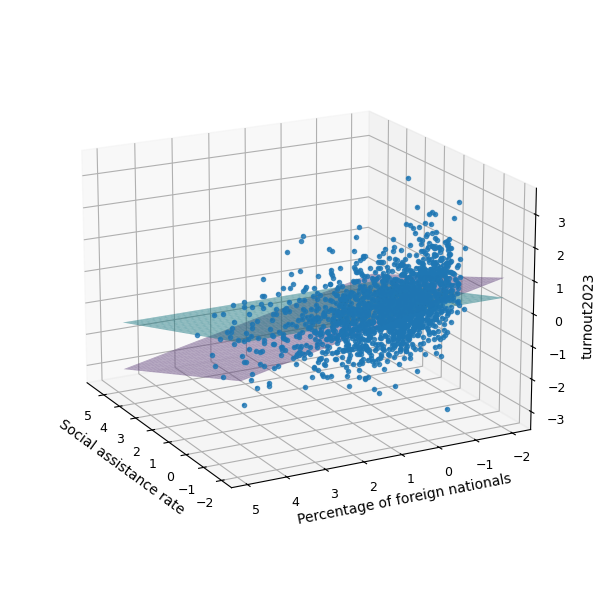

In [111]:
# Create 3D scatter plot with the regression planes
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Zoom the plot out to 0.9 so that axis labels are not cut off
ax.set_box_aspect(aspect=None, zoom=0.9)

# Set up plot
ax.plot(x2_std, x1_std, y_std, color='tab:blue', zorder=15, linestyle='none', marker='.', alpha=0.75)
#ax.plot(x2, x1, y, color='tab:blue', zorder=15, linestyle='none', marker='.', alpha=0.75)

# Scatter plot
ax.scatter(x2_std, x1_std, y_std, s=1)  
#ax.scatter(x2, x1, y, s=1) 

# Regression plane (Y depending pn X_1 and X_2)
ax.plot_surface(x2_mg, x1_mg, eq1, alpha=0.5, color="tab:purple")

# Hypothetical regression plane (Y depending on X_2)
ax.plot_surface(x2_mg, x1_mg, eq2, alpha=0.5, color="tab:cyan")

ax.set_xlabel(columnsX[1], fontsize=10) #"Social assistance rate"
ax.set_ylabel(columnsX[0], fontsize=10) # Percentage for foreeign nationals
ax.set_zlabel(columnY,     fontsize=10) # Voter turnout 2023

ax.view_init(elev=18, azim=152)

fig.tight_layout()

### Create 3D plots from 360 perspectives (parameter azim)

In [ ]:
jj = 1
degree_range = np.arange(1, 360, 1)

for ii in degree_range:
  # Use numbers 360 to 719 for file names (to be able to sort files easily, otherwise 1,11,2,22 etc.)
  jj = ii + 359
  ax.view_init(elev=18, azim=ii)
  # Use temporary directory since the files are only used for an intermediate step
  fig.savefig('tmp/scatterplot-%d.png' % jj, dpi=120, format="png")

In [ ]:
images_set = []

# Prepare images: Group files in 4 groups
file_range = np.arange(360, 718, 1)
images = [Image.open('tmp/scatterplot-%d.png' % x) for x in file_range]
images_set.append(images[0:89])
images_set.append(images[90:179])
images_set.append(images[180:269])
images_set.append(images[270:359])

In [ ]:
# Since we use the files in web app (HTML/JavaScript) it would be very unfavorable to load 360 image files
# (when images were to concatenated to one big JPG image, python raised an os buffer error, so we use 4 images)
# Therefore we concatenate the images to 4 jpg files
for i, image_set in enumerate(images_set):
  widths, heights = zip(*(i.size for i in image_set))
  new_im = Image.new('RGB', (sum(widths), max(heights)))
  x_offset = 0
  for im in image_set:
    new_im.paste(im, (x_offset, 0))
    x_offset += im.size[0]
    
  new_im.save('docs/scatterplot-3D-animated/scatterplot-3D-all-%d.jpg' % i)

In [ ]:
# https://skos.ch/fileadmin/user_upload/skos_main/public/pdf/grundlagen_und_positionen/themen/Soziale_Sicherheit/2019_BFS_Sozialhilfestatistik.pdf
# https://www.bfs.admin.ch/bfs/de/home/statistiken/soziale-sicherheit/sozialhilfe.assetdetail.23845655.html